In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

import torch, torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets

### 세팅 

In [2]:
# Computational device
# Device will be set to GPU if it is available.(you should install valid Pytorch version with CUDA. Otherwise, it will be computed using CPU)
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("Using Device:", DEVICE)

Using Device: cuda


In [3]:
# Fashion MNIST dataset
trainset = datasets.FashionMNIST(
    root      = './.data/', train = True,
    download  = True,
    transform = transforms.ToTensor())
testset = datasets.FashionMNIST(
    root      = './.data/', train     = False,
    download  = True,
    transform = transforms.ToTensor())

In [4]:
SELECT_NORMAL = 2 # Set 2 class as train dataset.
trainset.data = trainset.data[trainset.targets == SELECT_NORMAL]
trainset.targets = trainset.targets[trainset.targets == SELECT_NORMAL] # Set 2 class as train dataset.

test_label = [2,4,6] # Define actual test class that we use
actual_testdata = torch.isin(testset.targets, torch.tensor(test_label))
testset.data = testset.data[actual_testdata]
testset.targets = testset.targets[actual_testdata]

test_loader = torch.utils.data.DataLoader(
    dataset     = testset, batch_size  = 1,
    shuffle     = False,num_workers = 2)

train_data_size = len(trainset)
test_data_size = len(testset)

print("Train data size:", train_data_size, "Test data size:", test_data_size)

Train data size: 6000 Test data size: 3000


#### 데이터 증강 기법 사용 class 

In [5]:
class GaussianNoise(nn.Module):
    def __init__(self, std=0.1):
        super().__init__()
        self.std = std

    def forward(self, x):
        if self.training:
            noise = x.data.new(x.size()).normal_(0, self.std)
            return x + noise
        return x

In [6]:
# 몇 배로 Augmentation을 할 것인지 알려주면 해당 배수만큼 Augmentation을 수행하는 클래스
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    GaussianNoise(0.1)
])

class AugmentedDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None, augmentation_factor=1):
        '''
        dataset: 원본 데이터셋\
        transform: 증강을 위한 transform
        augmentation_factor: 몇 배로 Augmentation
        '''
        self.dataset = dataset
        self.transform = transform
        self.augmentation_factor = augmentation_factor
        self.original_length = len(dataset)

    def __len__(self):
        # 전체 데이터 수 = 원본 * 배수
        return self.original_length * self.augmentation_factor

    def __getitem__(self, idx):
        # 원본 인덱스를 순환해서 접근
        original_idx = idx % self.original_length
        x, y = self.dataset[original_idx]

        # 증강 적용
        if self.transform:
            x = self.transform(x)

        return x, y

In [ ]:
# 데이터셋을 먼저 train과 val로 나누고, train에 대해서만 증강을 적용
n_val = int(len(trainset) * 0.2)
n_train = len(trainset) - n_val
BATCH_SIZE = 128

augset, valset = torch.utils.data.random_split(trainset, [n_train, n_val], generator=torch.Generator().manual_seed(2025))

augset = AugmentedDataset(augset, transform=transform, augmentation_factor=10)

train_loader = torch.utils.data.DataLoader(
    dataset     = augset, batch_size  = BATCH_SIZE,
    shuffle     = True,num_workers = 0) 

val_loader = torch.utils.data.DataLoader(
    dataset     = valset, batch_size = BATCH_SIZE,
    shuffle     = False,num_workers = 0)

# data size check
print("Train data size:", len(augset),"Val data size:", len(valset),"Test data size:", len(testset))

Train data size: 48000 Val data size: 1200 Test data size: 3000


### 모델 및 Training Setting 

In [8]:
class EarlyStopping():
    def __init__(self, patience=10, verbose=False, delta=0):
        '''
        patience (int): 얼마나 기다릴지
        verbose (bool): True일 경우 각 epoch의 loss 출력
        delta (float): 개선이 되었다고 인정되는 최소한의 loss
        '''
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta

    def __call__(self, val_loss, model):
        score = -val_loss # validation loss가 작을수록 좋다고 가정

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''validation loss가 감소하면 모델을 저장한다.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

In [ ]:
class TrainSelector():
    def __init__(self, model, is_2d=True):
        self.model = model
        self.is_2d = is_2d
    
    def __call__(self, train_loader, optimizer, criterion):
        if self.is_2d:
            return self._train2d(self.model, train_loader,optimizer,criterion)
        else:
            return self._train1d(self.model, train_loader,optimizer,criterion)
    
    @staticmethod
    def _train2d(model, train_loader, optimizer, criterion):
        model.train()
        train_loss = 0
        for data, _ in train_loader:
            data = data.to(DEVICE)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, data)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        return train_loss / len(train_loader) # Average loss per batch
    
    @staticmethod
    def _train1d(model,train_loader,optimizer,criterion):
        model.train()
        train_loss = 0
        for data, _ in train_loader:
            data = data.to(DEVICE).view(-1, 28*28) # Flatten 2D data to 1D
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, data)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        return train_loss / len(train_loader) # Average loss per batch
    
class EvaluateSelector():
    def __init__(self, model, is_2d=True):
        self.model = model
        self.is_2d = is_2d
    
    def __call__(self, eval_loader, criterion):
        if self.is_2d:
            return self._evaluate2d(self.model, eval_loader, criterion)
        else:
            return self._evaluate1d(self.model, eval_loader, criterion)
    
    @staticmethod
    def _evaluate2d(model, eval_loader, criterion):
        model.eval()
        eval_loss = 0
        with torch.no_grad():
            for data, _ in eval_loader:
                data = data.to(DEVICE)
                output = model(data)
                loss = criterion(output, data)
                eval_loss += loss.item()
        return eval_loss / len(eval_loader) # Average loss per batch
    
    @staticmethod
    def _evaluate1d(model, eval_loader, criterion):
        model.eval()
        eval_loss = 0
        with torch.no_grad():
            for data, _ in eval_loader:
                data = data.to(DEVICE).view(-1, 28*28) # Flatten 2D data to 1D
                output = model(data)
                loss = criterion(output, data)
                eval_loss += loss.item()
        return eval_loss / len(eval_loader) # Average loss per batch

In [10]:
from model.autoencoder import Autoencoder2D, Autoencoder
from torch.utils.tensorboard import SummaryWriter
model = Autoencoder2D().to(DEVICE) # Autoencoder2D is used for 2D data.

EPOCH = 1000
LEARNING_RATE = 0.0001
Criterion = nn.MSELoss() # Mean Squared Error is used as loss function.
Optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE) # AdamW optimizer is used.

### Training

In [11]:
# Training process
writer = SummaryWriter()
early_stopping = EarlyStopping(patience=10, verbose=True)
train_selector = TrainSelector(model, is_2d=True)
evaluate_selector = EvaluateSelector(model, is_2d=True)

for epoch in range(EPOCH):
    train_loss = train_selector(train_loader, Optimizer, Criterion)
    val_loss = evaluate_selector(val_loader, Criterion)
    print(f'Epoch {epoch} Train Loss: {train_loss:.4f} Validation Loss: {val_loss:.4f}')
    writer.add_scalars('Loss', {'train': train_loss, 'val': val_loss}, epoch)
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

# Ensure the model is loaded back to the same device (GPU or CPU)
model.load_state_dict(torch.load('checkpoint.pt', map_location=DEVICE))
writer.close()

Epoch 0 Train Loss: 0.2906 Validation Loss: 0.0804
Validation loss decreased (inf --> 0.080368).  Saving model ...
Epoch 1 Train Loss: 0.0780 Validation Loss: 0.0612
Validation loss decreased (0.080368 --> 0.061154).  Saving model ...
Epoch 2 Train Loss: 0.0710 Validation Loss: 0.0581
Validation loss decreased (0.061154 --> 0.058064).  Saving model ...
Epoch 3 Train Loss: 0.0689 Validation Loss: 0.0562
Validation loss decreased (0.058064 --> 0.056181).  Saving model ...
Epoch 4 Train Loss: 0.0675 Validation Loss: 0.0547
Validation loss decreased (0.056181 --> 0.054658).  Saving model ...
Epoch 5 Train Loss: 0.0663 Validation Loss: 0.0534
Validation loss decreased (0.054658 --> 0.053362).  Saving model ...
Epoch 6 Train Loss: 0.0653 Validation Loss: 0.0520
Validation loss decreased (0.053362 --> 0.051958).  Saving model ...
Epoch 7 Train Loss: 0.0645 Validation Loss: 0.0511
Validation loss decreased (0.051958 --> 0.051137).  Saving model ...
Epoch 8 Train Loss: 0.0638 Validation Loss: 0

### TEST

In [12]:
# Test batch size should be 1 for this case.
THRESHOLDVAL=0.01 # threshold val
dic_loss = {'id':[], 'label':[], 'score':[],'normal':[]}

for step, (x, label) in enumerate(test_loader):
    x = x.to(DEVICE)
    output = model(x)
    loss = F.mse_loss(output, x, reduction='none').view(-1, 784).mean(dim=1)
    loss = loss = float(loss.cpu().detach().numpy().item())
    dic_loss['id'].append(step)
    dic_loss['label'].append(int(label==SELECT_NORMAL))
    dic_loss['score'].append(loss)
    # 0: anomaly, 1: normal (loss < threshold)
    dic_loss['normal'].append(str(int(loss<THRESHOLDVAL)))


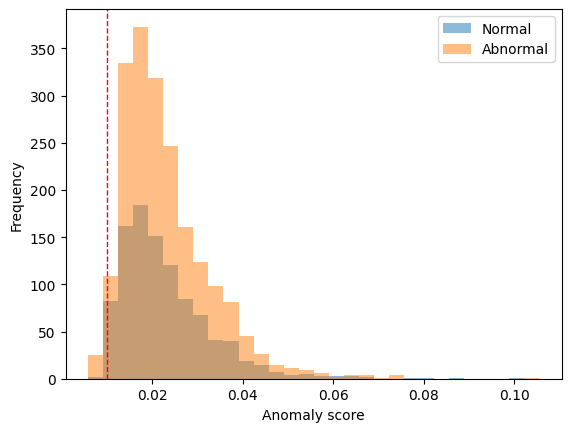

In [13]:
# Gernerating a plot
arr_label = np.array(dic_loss['label'])
arr_score = np.array(dic_loss['score'])
score_min = arr_score.min()
score_max = arr_score.max()
plt.hist(arr_score[np.where(arr_label == 1)[0]], bins=30, range=(score_min, score_max), alpha=0.5, label='Normal')
plt.hist(arr_score[np.where(arr_label == 0)[0]], bins=30, range=(score_min, score_max), alpha=0.5, label='Abnormal')
plt.xlabel("Anomaly score")
plt.ylabel("Frequency")
plt.axvline(THRESHOLDVAL,0,1, color='red',linestyle='--',linewidth=1)
plt.legend(loc='upper right')
plt.savefig("plot.png")
plt.show()

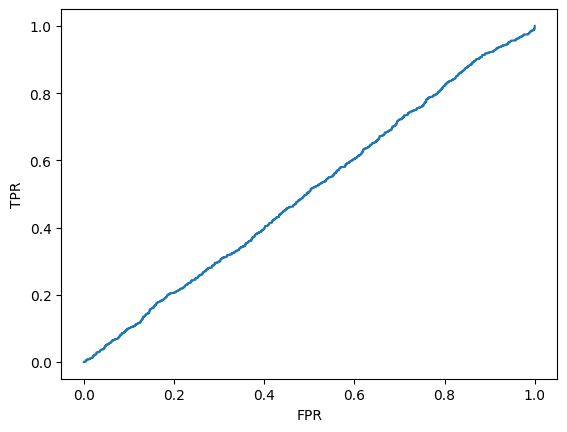

AUROC: 0.506482


In [14]:
# Generating AUROC
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html
fpr, tpr, thresholds = roc_curve(dic_loss['label'], dic_loss['score'], pos_label=0)
plt.plot(fpr, tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.savefig("auroc.png")
plt.show()
auroc = auc(fpr, tpr)
print("AUROC: {}".format(auroc))

In [15]:
# Leveraging the pandas library to convert a dict to a dataframe is more convenient when checking values.
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_csv.html
df = pd.DataFrame.from_dict(dic_loss)
df 

,id,label,score,normal
0,0,1,0.043621,0
1,1,0,0.020812,0
2,2,0,0.033370,0
3,3,0,0.032988,0
4,4,0,0.014469,0
...,...,...,...,...
2995,2995,0,0.014919,0
2996,2996,0,0.020367,0
2997,2997,1,0.033914,0
2998,2998,0,0.036376,0


In [16]:
# In order to submit .csv file to kaggle, dataframe should fit following format
# id[1,2,3...,3000], predicted anomalies[0,1,0....,0]

# 'pop('score,None')' delete one of the item in dict
# 'del df['item']', is also available.

# If you try to remove invalid itmes in the dict, message that you set will be returned.
# set to None, nothing will be returned
dic_loss.pop('score',None)
dic_loss.pop('label',None)
df = pd.DataFrame.from_dict(dic_loss)
df

,id,normal
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
2995,2995,0
2996,2996,0
2997,2997,0
2998,2998,0


In [17]:
# to_csv command will convert your dict to .csv file with the name of your teamnumber
# Do not forget to submit the .csv file to kaggle. If you upload .csv file properly to kaggle, you can check your result immediately at the leaderboard.
teamnumber = 8 # insert your teamnumber
df.to_csv("result_team{}.csv".format(teamnumber), index =False) # Index should be not included in the .csv file.
torch.save(model.state_dict(), 'model_team{}.pth'.format(teamnumber))